In [1]:
%load_ext Cython
import numpy as np
import matplotlib.pyplot as plt

%matplotlib notebook
%load_ext autoreload
%load_ext autotime
%autoreload 2

time: 870 µs


In [2]:
%%cython
import array
import numpy as np
import math
cimport numpy as np

#Henon iteration
def henon_map_2d(double xini, double pini, double mu, long nit, int step=5, int shift=0):   
    cdef int data_len=nit//step
    cdef np.ndarray xarr = np.zeros(data_len, dtype=np.float64)
    cdef np.ndarray parr = np.zeros(data_len, dtype=np.float64)
    cdef int i
    cdef long double cm=math.cos(mu)
    cdef long double sm=math.sin(mu)
    cdef double pmxx
    cdef double x, p    
    x=xini
    p=pini
    for i in range(shift):
        pmxx=(p-x*x)
        p=-x*sm+pmxx*cm
        x=x*cm+pmxx*sm
    for i in range(data_len):
        xarr[i]=x
        parr[i]=p
        for j in range(step):
            pmxx=(p-x*x)
            p=-x*sm+pmxx*cm
            x=x*cm+pmxx*sm        
    return xarr,parr

time: 69.2 ms


In [3]:
tune=0.205
N=int(5*10**3)
step = int(1)
x_tr = []
p_tr = []
xini_N = int(10**2)
pini_N = int(xini_N/2)
xini_arr = []
pini_arr= []
x_range = 1
p_range = x_range

for xini in np.linspace(0, x_range, xini_N):
    for pini in np.linspace(0, p_range, pini_N):
        
        x,p=henon_map_2d(xini,pini,tune*2*np.pi, N, step=step)
        
        if np.isnan(np.max(x)):
            break
        else:
            x_tr.append(x)
            p_tr.append(p)

            xini_arr.append(xini)
            pini_arr.append(pini)

time: 1.51 s


In [4]:
data_in = np.zeros( (len(xini_arr), 2), dtype=np.float64)
data_out = np.zeros(len(xini_arr), dtype=np.float64)

for i in range(len(xini_arr)):
    data_out[i] = x_tr[i][-1]
    for j in range(2):
        if j==0:
            data_in[i,j] = xini_arr[i]
        elif j==1:
            data_in[i,j] = pini_arr[i]
            
print(np.shape(data_in))
print(len(xini_arr))

(1854, 2)
1854
time: 7.24 ms


In [5]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

gp = GaussianProcessRegressor()
gp.fit(data_in, data_out)

GaussianProcessRegressor()

time: 4.4 s


In [10]:
N_test = int(1e2)
x_test_range=0.5
p_test_range=x_test_range
data_test = np.zeros((N_test, 2), dtype=np.float64)
x_test = np.linspace(0,x_test_range,N_test)
p_test = np.linspace(0,p_test_range,N_test)
for i in range(N_test):
    for j in range(2):
        if j==0:
            data_test[i,j] = x_test[i]
        else:
            data_test[i,j] = p_test[i]

x_pred, MSE = gp.predict(data_test, return_std=True)
print(len(x_pred))

100
time: 50.7 ms


/home/kjanderson248/.local/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


[0.         0.         0.         ... 0.62626263 0.62626263 0.62626263]


<IPython.core.display.Javascript object>


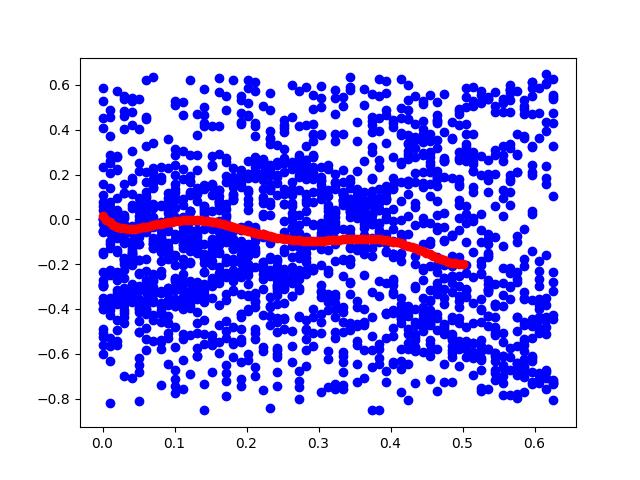

time: 45.6 ms


In [14]:
print(data_in[:,0])
plt.scatter(data_in[:,0], data_out, c='b')
plt.scatter(x_test, x_pred, c='r')